In [12]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

from pathlib import Path
from sklearn.model_selection import train_test_split

In [13]:
def fill_missing_data(data):
    for label, content in data.items():
        # Check for which numeric columns have null values
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing
                data[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                data[label] = content.fillna(content.median())
            # Check for which categorial columns have null values
        elif not pd.api.types.is_numeric_dtype(content):
            # Add binary column to indicate whether sample had missing value
            data[label+"_is_missing"] = pd.isnull(content)
            # Turn categories into numbers and add +1 (missing values == -1)
            data[label] = pd.Categorical(content).codes + 1


def string_cols_to_category(data):
    # This will turn all of the string values into category values
    for label, content in data.items():
        if pd.api.types.is_string_dtype(content):
            data[label] = content.astype("category").cat.as_ordered()


class DataModel(object):
    train = ()
    valid = ()
    test = ()

    X_train = None
    X_test = None
    X_valid = None
    y_train = None
    y_test = None
    y_valid = None

    _TRAINING_SIZE = 0.7
    _VALIDATION_SIZE = 0.15
    _TEST_SIZE = 0.15
    _X = None
    _y = None

    def __init__(self, X, y, train_size=0.7, valid_size=0.15, test_size=0.15):
        split_size = train_size + valid_size + test_size
        if split_size != 1:
            msg = "Combined split sizes must equal 1."
            raise ValueError(f"{msg} Current split size={split_size}")

        self._TRAINING_SIZE = train_size
        self._VALIDATION_SIZE = valid_size
        self._TEST_SIZE = test_size
        self._X = X
        self._y = y

    def split_train_test_validation(self, data):
        len_df = len(data)
        train_split = round(self._TRAINING_SIZE * len_df)
        valid_split = round(train_split + self._VALIDATION_SIZE * len_df)

        self.train = (self._X[:train_split],
                      self._y[:train_split])

        self.valid = (self._X[train_split:valid_split],
                      self._y[train_split:valid_split])

        self.test = (self._X[valid_split:],
                     self._y[valid_split:])

        return (self.train, self.valid, self.test)

    def split_train_test(self, test_size=None):
        if not test_size:
            test_size = self._TEST_SIZE

        (self.X_train,
         self.X_test,
         self.y_train,
         self.y_test) = train_test_split(
            self._X, self._y, test_size=test_size)

    def split_train_valid(self, column):
        # Split training and validation data into
        self.X_train, self.y_train = self._X.drop(
            column, axis=1), self._X[column]
        self.X_valid, self.y_valid = self._y.drop(
            column, axis=1), self._y[column]


In [14]:
class Tensor_Image(DataModel):    
    truth_labels = None
    
    def __init__(self, X, y, train_size=0.7, valid_size=0.15, test_size=0.15,
                 img_size=224, batch_size=32):
        super().__init__(X, y, train_size, valid_size, test_size)
        self._IMG_SIZE = img_size
        self._BATCH_SIZE = batch_size
        self._X = X
        self._y = y        
    
    def process_image(self, image_path):
        """
        Takes an image file path and turns the image into a Tensor.
        """
        # Read in an image file
        image = tf.io.read_file(image_path)
        # Turn our image into numerical Tensor with 3 color channels (RGB)
        image = tf.image.decode_jpeg(image, channels=3)
        # Convert the color channel values from 0-255 to 0-1 values
        image = tf.image.convert_image_dtype(image, tf.float32)
        # Resize the image
        image = tf.image.resize(image, size=[self._IMG_SIZE, self._IMG_SIZE])

        return image

    def get_image_label(self, image_path, label):
        """
        Takes an image file path name and the associated label,
        process the image and returns a tuple of (image, label)
        """
        image = self.process_image(image_path)
        return image, label
        
    def create_data_batches(self, valid_data=False, test_data=False):
        """
        Creates batches of data out of image (X) and label (y) pairs.
        It shuffles the data if it's training data but doesnt shuffle
        if its validation data.
        Also accepts test data as input (no labels).
        """

        # If the data is a test data set, we probably don't have labels
        if test_data:
            data = tf.data.Dataset.from_tensor_slices(
                (tf.constant(self.X_test)))  # only filepaths
            self.test = data.map(self.process_image).batch(self._BATCH_SIZE)
        # If the data is a valid dataset, we dont need to shuffle it.
        elif valid_data:
            data = tf.data.Dataset.from_tensor_slices((tf.constant(self.X_valid), # filepaths
                                               tf.constant(self.y_valid))) # labels
            self.valid = data.map(self.get_image_label).batch(self._BATCH_SIZE)
        else:
            # Turn filepaths and labels into Tensors
            data = tf.data.Dataset.from_tensor_slices((tf.constant(self.X_train),
                                                      tf.constant(self.y_train)))

            # Shuffle before mapping image processor function is faster
            data = data.shuffle(buffer_size=len(self.X_train))
            data = data.map(self.get_image_label)

            # Finally turn the training data into batches
            self.train = data.batch(self._BATCH_SIZE)    

    def create_model(self, model_url: str,
         input_shape: list = None,
         output_shape: list = None,
         activation="softmax", metrics="accuracy"):
        """Defines the layers in a Keras model in a sequential fashion, then
        compiles and builds the model.

        Args:
            model_url (str): model URL from TensorFlow Hub
            input_shape (list, optional): input shape to the model.
                Defaults to None.
            activation (str, optional): layer density activation.
                Defaults to "softmax".
            metrics (str, optional): metric to be evaluated by the model.
                Defaults to "accuracy".

        Returns:
            tf.keras.Sequential: the keras model
        """
        if not input_shape:
            input_shape = [self._IMG_SIZE, self._IMG_SIZE, 3]

        # Setup model layers
        model = tf.keras.Sequential([
            hub.KerasLayer(model_url),
            tf.keras.layers.Dense(units=output_shape,
                                  activation=activation)
        ])

        # Compile the model
        model.compile(
            loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[metrics]
        )

        # Build the model
        model.build(input_shape)

        return model

    def train_model(self, input_shape, output_shape, model_url,
                    epochs, logpath, strftime):
        """
        Trains a given model and returns the trained version.
        """
        # Create a model
        model = self.create_model(model_url, input_shape, output_shape)

        # Create new TensorBoard session everytime we train a model
        tensorboard = self.create_tensorboard_callback(logpath=logpath, strftime=strftime)
        
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="accuracy",
            patience=3)

        # Fit the model to the data passing it the callbacks we created
        model.fit(x=self.train,
                epochs=epochs,
                validation_data=self.valid,
                validation_freq=1, # check validation metrics every epoch
                callbacks=[tensorboard, early_stopping])

        return model

    # Create a function to build a TensorBoard callback
    def create_tensorboard_callback(self, logpath: str,
                                    strftime: str = "%Y%m%d-%H%M%S"):
        """Save logs to a directory and pass it to the model's fit() function

        Args:
            logpath (str): path to store log files
            strftime (str, optional): datetime string format.
                Defaults to "%Y%m%d-%H%M%S".

        Returns:
            tf.keras.callbacks.TensorBoard: the TensorBoard
        """
        # Create a log directory for storing TensorBoard logs
        logdir = Path(
            logpath, datetime.datetime.now().strftime(strftime))

        return tf.keras.callbacks.TensorBoard(logdir)

    def split_train_valid(self, test_size=None):
        if not test_size:
            test_size = self._TEST_SIZE

        (self.X_train,
         self.X_valid,
         self.y_train,
         self.y_valid) = train_test_split(
            self._X, self._y, test_size=test_size)
        
    # Turn prediction probabilities into their respective label (easier to understand)
    def get_pred_label(self, prediction_probabilities):
        """
        Turns an array of prediction probabilities into a label.
        """
        return self.truth_labels[np.argmax(prediction_probabilities)]
    
    # Create a function to unbatch a batch dataset
    def unbatchify(self, data):
        """
        Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
        """
        images = []
        labels = []

        #loop through unbatched data
        for image, label in data.unbatch().as_numpy_iterator():
            images.append(image)
            labels.append(self.truth_labels[np.argmax(label)])

        return images, labels
    
    def plot_pred(self, prediction_probabilities, images, labels, n=1):
        """
        View the prediction, ground truth, and image for sample n
        """
        pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

        # Get tje pred label
        pred_label = self.get_pred_label(pred_prob)

        # Plot image & remove ticks
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])

        # Change the color of the title depending if the prediction is right or wrong
        if pred_label == true_label:
            color = "green"
        elif pred_label != true_label:
            color = "red"

        # Change plot title to be predicted, probability of prediction, and truth
        plt.title("{} {:2.0f}% {}".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                 color=color)
        
    def plot_pred_conf(self, prediction_probabilities, labels, n=1):
        """
        Plus the top 10 highest prediction confidences along with the truth label for sample n.
        """
        pred_prob, true_label = prediction_probabilities[n], labels[n]

        # Get the predicted label
        pred_label = self.get_pred_label(pred_prob)

        # Find the top 10 prediction confidence indexes
        top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

        # Find the top 10 prediction confidence values
        top_10_pred_values = pred_prob[top_10_pred_indexes]

        # Find the top 10 prediction labels
        top_10_pred_labels = self.truth_labels[top_10_pred_indexes]

        # Setup plot
        top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                         top_10_pred_values,
                         color="grey")
        plt.xticks(np.arange(len(top_10_pred_labels)),
                 labels= top_10_pred_labels,
                 rotation="vertical")

        # Change color of true labels
        if np.isin(true_label, top_10_pred_labels):
            top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")

    def visualize_predictions(self, prediction_probabilities,
                              i_multiplier=10,
                              num_rows=3, 
                              num_cols=2):

        images, labels = self.unbatchify(self.valid)
        
        num_images = num_rows * num_cols
        plt.figure(figsize=(10*num_cols, 5*num_rows))

        for i in range(num_images):
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            self.plot_pred(predictions, labels=labels, images=images, n=i+i_multiplier)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            self.plot_pred_conf(predictions, labels=labels, n=i+i_multiplier)

        plt.tight_layout(h_pad=1.0)
        plt.show()
        
    # Create a function to save a model
    def save_model(model, filepath, strftime, suffix=None):
        """
        Saves a given model in a models directory and appends a suffix (str).
        """
        # Create a model directory pathname with current time
        models_dir = Path(filepath)
        date_time = datetime.datetime.now().strftime(strftime)
        file_name = date_time + "-" + suffix + ".h5"

        model_path = models_dir / file_name # save model format

        model.save(model_path)
        return model_path
    
    
    # Create a function to load a trained model
    def load_model(filepath):
        """
        Loads a saved model from a specified path.
        """
        model = tf.keras.models.load_model(filepath,
                                         custom_objects={"KerasLayer":hub.KerasLayer})
        return model
    
    def save_predictions_to_csv(self, prediction_probabilities, image_names, filepath):
        preds_df = pd.DataFrame(columns=["id"] + list(self.truth_labels))
        ids = [Path(path).stem for path in image_names]
        preds_df["id"] = test_ids
        preds_df[list(self.truth_labels)] = prediction_probabilities
        preds_df.to_csv(filepath, index=False)
        

In [15]:
# Lets use the classes from the common utils for a full blown test
import numpy as np
import pandas as pd

from pathlib import Path

# Set the random seed
np.random.seed(42)

CWD_PATH = Path.cwd().parent
DOG_VISION = CWD_PATH / "images/Dog Vision"

labels_csv = pd.read_csv(DOG_VISION / "labels.csv")
labels = labels_csv['breed'].to_numpy()
unique_labels = np.unique(labels)

# Set the number of images
NUM_IMAGES = 1000
# Set the image size
IMG_SIZE = 224
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels
# Setup output shape of the model
OUTPUT_SHAPE = len(unique_labels)
# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5"
NUM_EPOCHS = 100
logpath = DOG_VISION / "cb_logs"
strftime = "%Y%m%d-%H%M%S"

# Setup X & y variables
X = [str(DOG_VISION / f"train/{fname}.jpg") for fname in labels_csv["id"]]
y = [label == unique_labels for label in labels]

# create the datamodel of total size NUM_IMAGES
data_model = Tensor_Image(X[:NUM_IMAGES], y[:NUM_IMAGES], img_size=IMG_SIZE)

data_model.truth_labels = unique_labels

# Split them into training and validation 
data_model.split_train_valid()

# Create training and validation data batches
data_model.create_data_batches()
data_model.create_data_batches(valid_data=True)

In [16]:
# Make predictions on the validation data (not used to train on)
trained_model = data_model.train_model(input_shape=INPUT_SHAPE,
                       output_shape=OUTPUT_SHAPE,
                       model_url=MODEL_URL, 
                       epochs=NUM_EPOCHS, 
                       logpath=logpath, strftime=strftime)

Epoch 1/100


2023-03-30 12:41:25.096361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [850]
	 [[{{node Placeholder/_0}}]]
2023-03-30 12:41:25.096639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype bool and shape [850,120]
	 [[{{node Placeholder/_1}}]]
2023-03-30 12:41:26.214341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPa

2023-03-30 12:41:26.567366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,1001]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-03-30 12:41:26.567504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_5' with dtype float and shape [?,14,14,528]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_5}}]]
2023-03-30 12:41:26.567591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) E

27/27 [==============================] - ETA: 0s - loss: 4.6398 - accuracy: 0.0694

2023-03-30 12:41:43.025334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype bool and shape [150,120]
	 [[{{node Placeholder/_1}}]]


27/27 [==============================] - 21s 665ms/step - loss: 4.6398 - accuracy: 0.0694 - val_loss: 3.5043 - val_accuracy: 0.2200
Epoch 2/100
27/27 [==============================] - 17s 624ms/step - loss: 1.5801 - accuracy: 0.7259 - val_loss: 2.1698 - val_accuracy: 0.5000
Epoch 3/100
27/27 [==============================] - 18s 662ms/step - loss: 0.5233 - accuracy: 0.9553 - val_loss: 1.6426 - val_accuracy: 0.6133
Epoch 4/100
27/27 [==============================] - 18s 664ms/step - loss: 0.2328 - accuracy: 0.9953 - val_loss: 1.4463 - val_accuracy: 0.6667
Epoch 5/100
27/27 [==============================] - 19s 688ms/step - loss: 0.1380 - accuracy: 1.0000 - val_loss: 1.3638 - val_accuracy: 0.6667
Epoch 6/100
27/27 [==============================] - 19s 702ms/step - loss: 0.0945 - accuracy: 1.0000 - val_loss: 1.3149 - val_accuracy: 0.6867
Epoch 7/100
27/27 [==============================] - 19s 710ms/step - loss: 0.0716 - accuracy: 1.0000 - val_loss: 1.2733 - val_accuracy: 0.6933
Epoc

In [17]:
print(trained_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              6158505   
                                                                 
 dense_1 (Dense)             (None, 120)               120240    
                                                                 
Total params: 6,278,745
Trainable params: 120,240
Non-trainable params: 6,158,505
_________________________________________________________________
None


In [18]:
# Make predictions on the validation data (not used to train on)
predictions = trained_model.predict(data_model.valid, verbose=1)

5/5 [==============================] - 3s 555ms/step


2023-03-30 12:43:57.678690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype bool and shape [150,120]
	 [[{{node Placeholder/_1}}]]


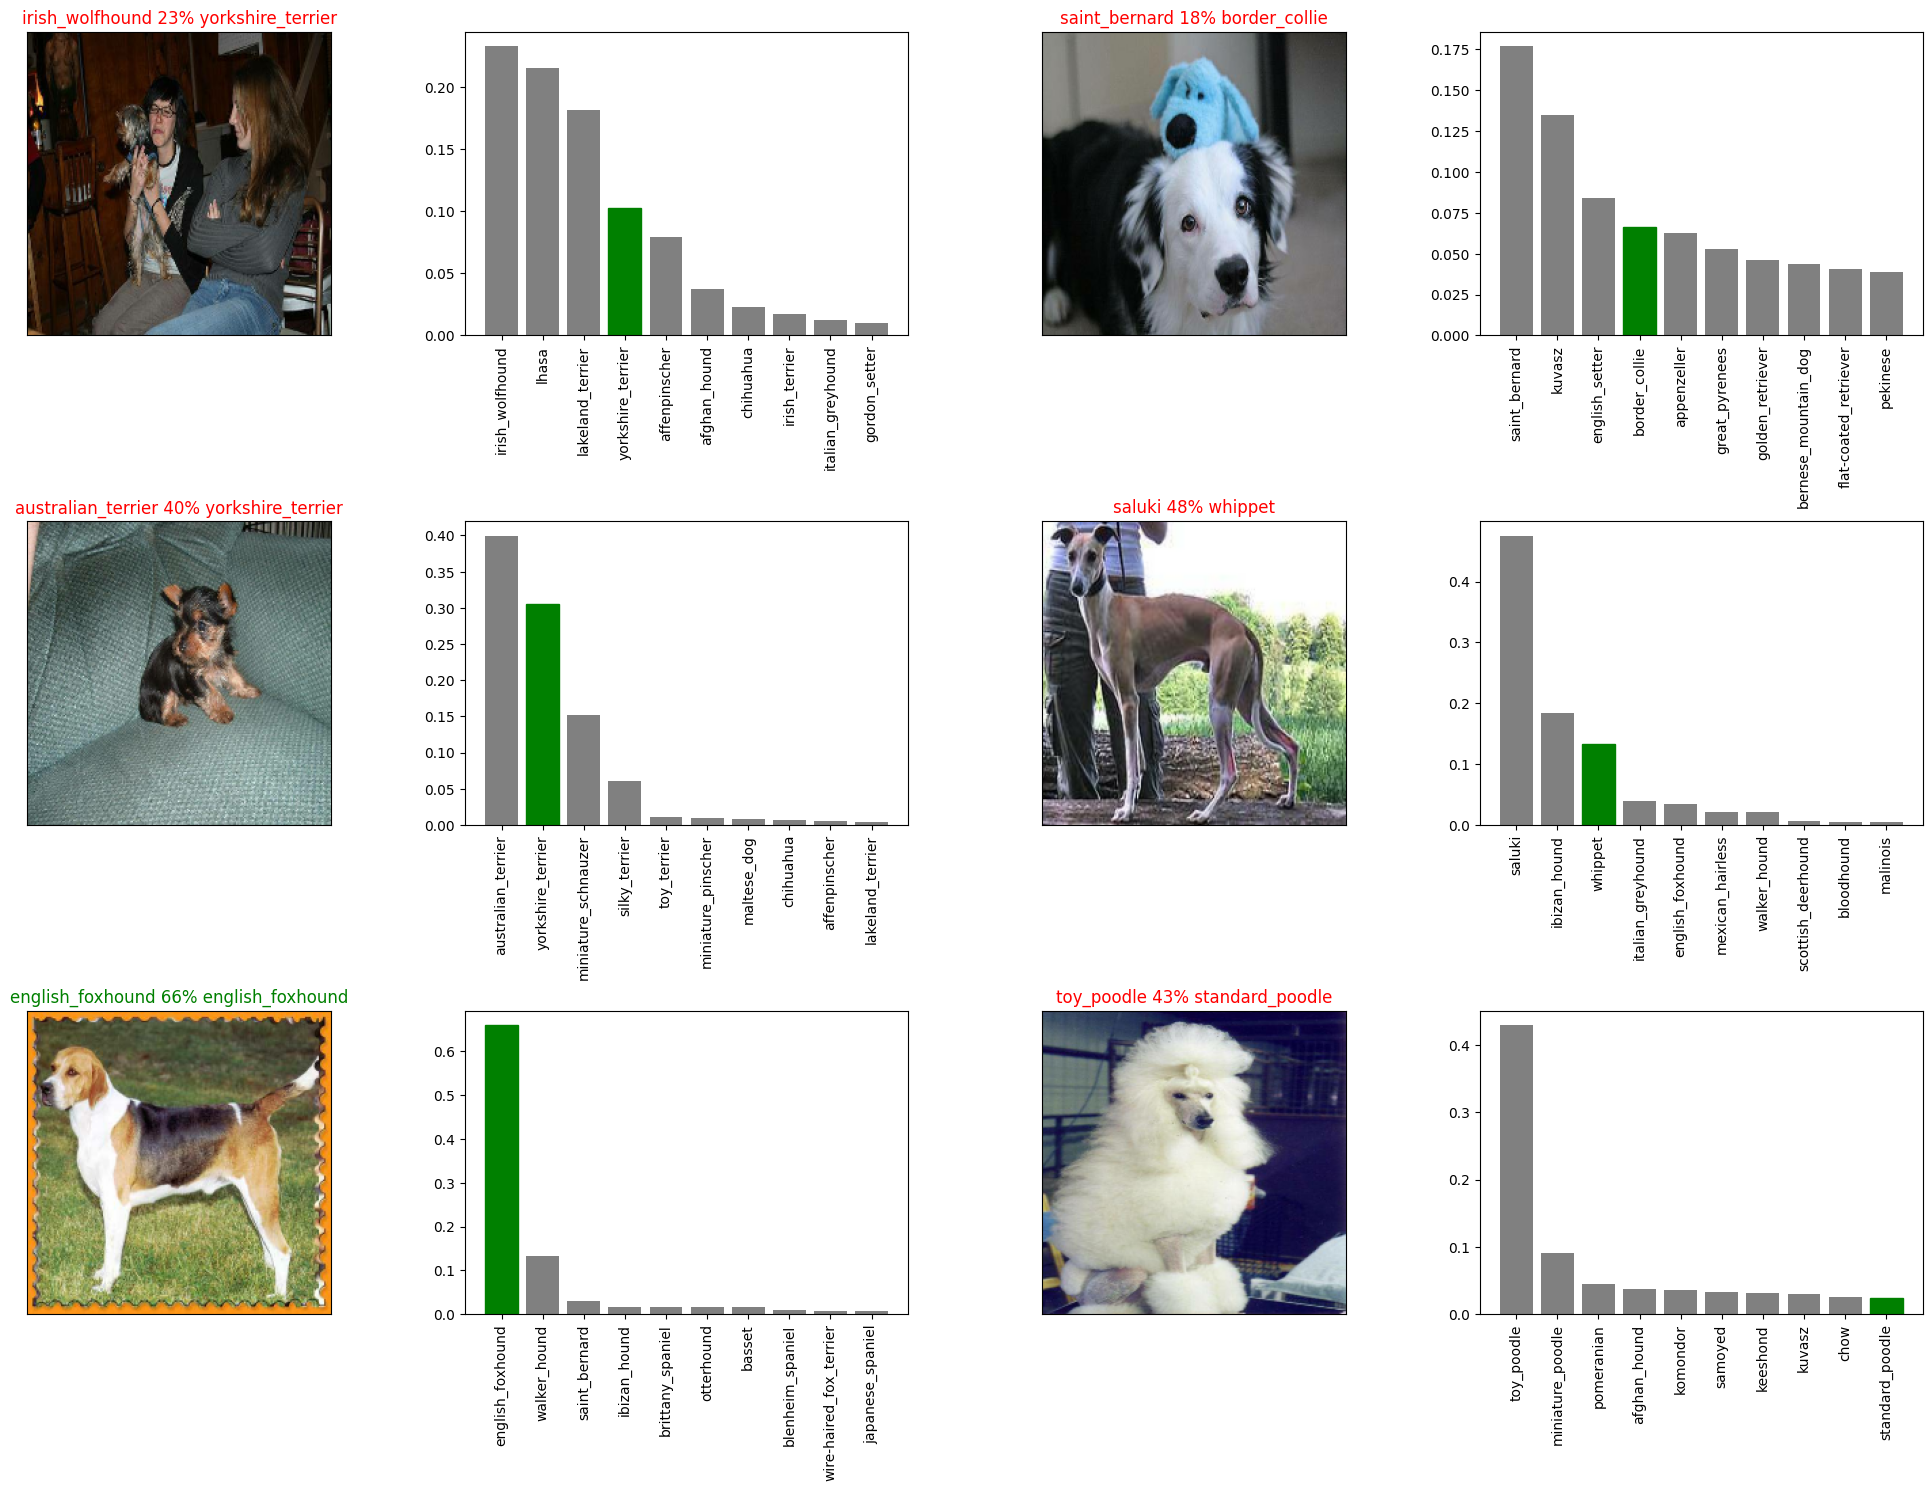

In [19]:
data_model.visualize_predictions(predictions)